In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

2024-08-06 08:24:30.123882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 08:24:30.123984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 08:24:30.244915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
image_path="/kaggle/input/face-expression-recognition-dataset/images/train"

train_path="/kaggle/input/face-expression-recognition-dataset/images/train"
valid_path="/kaggle/input/face-expression-recognition-dataset/images/validation"

In [4]:
# Define the list of class names (folders)
class_names = [folder for folder in os.listdir(image_path) if os.path.isdir(os.path.join(image_path, folder))]

In [5]:
class_names

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

In [6]:
number_of_images = {}
for class_name in class_names:
    number_of_images[class_name] = len(os.listdir(image_path+"/"+class_name))

images_per_class = pd.DataFrame(list(number_of_images.items()), columns=['Class Name', 'Number of Images'])
images_per_class

,Class Name,Number of Images
0,surprise,3205
1,fear,4103
2,angry,3993
3,neutral,4982
4,sad,4938
5,disgust,436
6,happy,7164


In [7]:
# Training data generator with data augmentation
traindata_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (rescaling only)
validdata_generator = ImageDataGenerator(rescale=1./255)

In [8]:
# Training data
train_generator = traindata_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validation data
validation_generator = validdata_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [9]:
# Load MobileNetV2 with pre-trained weights and exclude the top layers
mobilenetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Freeze the base model
for layer in mobilenetV2_model.layers:
    layer.trainable = False
    
# Adding custom layers on top of the base model
x = mobilenetV2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
prediction = Dense(7, activation='softmax')(x)

In [11]:
# Create the final model
model = Model(inputs=mobilenetV2_model.input, outputs=prediction)

In [12]:
# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,100,167 (15.64 MB)

 Trainable params: 1,841,159 (7.02 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [14]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [15]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/901 ━━━━━━━━━━━━━━━━━━━━ 4:44:07 19s/step - accuracy: 0.1250 - loss: 3.2325

I0000 00:00:1722932714.079715      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722932714.116726      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 73/901 ━━━━━━━━━━━━━━━━━━━━ 7:39 555ms/step - accuracy: 0.2692 - loss: 2.3153

W0000 00:00:1722932753.989610      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.3515 - loss: 1.7853

W0000 00:00:1722933127.609950      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


901/901 ━━━━━━━━━━━━━━━━━━━━ 472s 504ms/step - accuracy: 0.3515 - loss: 1.7850 - val_accuracy: 0.4265 - val_loss: 1.6382 - learning_rate: 0.0010
Epoch 2/20


W0000 00:00:1722933167.344934      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


901/901 ━━━━━━━━━━━━━━━━━━━━ 315s 346ms/step - accuracy: 0.4088 - loss: 1.5298 - val_accuracy: 0.4479 - val_loss: 1.4637 - learning_rate: 0.0010
Epoch 3/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 316s 348ms/step - accuracy: 0.4234 - loss: 1.5014 - val_accuracy: 0.4553 - val_loss: 1.4325 - learning_rate: 0.0010
Epoch 4/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 315s 348ms/step - accuracy: 0.4332 - loss: 1.4712 - val_accuracy: 0.4312 - val_loss: 1.5219 - learning_rate: 0.0010
Epoch 5/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 313s 345ms/step - accuracy: 0.4428 - loss: 1.4597 - val_accuracy: 0.4226 - val_loss: 1.5397 - learning_rate: 0.0010
Epoch 6/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 314s 345ms/step - accuracy: 0.4493 - loss: 1.4383 - val_accuracy: 0.4451 - val_loss: 1.4454 - learning_rate: 0.0010
Epoch 7/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 312s 344ms/step - accuracy: 0.4592 - loss: 1.4053 - val_accuracy: 0.4846 - val_loss: 1.3642 - learning_rate: 2.0000e-04
Epoch 8/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 314s 346ms/step - accuracy: 0.4

In [16]:
# Unfreeze the base model and fine-tune
for layer in mobilenetV2_model.layers:
    layer.trainable = True

In [17]:
# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
  1/901 ━━━━━━━━━━━━━━━━━━━━ 14:27:15 58s/step - accuracy: 0.1562 - loss: 1.9077

W0000 00:00:1722939237.000920      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


751/901 ━━━━━━━━━━━━━━━━━━━━ 57s 381ms/step - accuracy: 0.2988 - loss: 1.8242

W0000 00:00:1722939522.912557      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.3068 - loss: 1.8022

W0000 00:00:1722939575.176510      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


901/901 ━━━━━━━━━━━━━━━━━━━━ 407s 388ms/step - accuracy: 0.3068 - loss: 1.8021 - val_accuracy: 0.4130 - val_loss: 1.5533 - learning_rate: 1.0000e-05
Epoch 2/10


W0000 00:00:1722939585.975195      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


901/901 ━━━━━━━━━━━━━━━━━━━━ 320s 352ms/step - accuracy: 0.4323 - loss: 1.4747 - val_accuracy: 0.4322 - val_loss: 1.5032 - learning_rate: 1.0000e-05
Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 318s 350ms/step - accuracy: 0.4707 - loss: 1.3796 - val_accuracy: 0.4483 - val_loss: 1.4562 - learning_rate: 1.0000e-05
Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 321s 353ms/step - accuracy: 0.5127 - loss: 1.2895 - val_accuracy: 0.4772 - val_loss: 1.3594 - learning_rate: 1.0000e-05
Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 319s 352ms/step - accuracy: 0.5268 - loss: 1.2447 - val_accuracy: 0.5089 - val_loss: 1.2917 - learning_rate: 1.0000e-05
Epoch 6/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 319s 351ms/step - accuracy: 0.5418 - loss: 1.2021 - val_accuracy: 0.5253 - val_loss: 1.2412 - learning_rate: 1.0000e-05
Epoch 7/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 321s 354ms/step - accuracy: 0.5633 - loss: 1.1578 - val_accuracy: 0.5644 - val_loss: 1.1572 - learning_rate: 1.0000e-05
Epoch 8/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 348s 383ms/

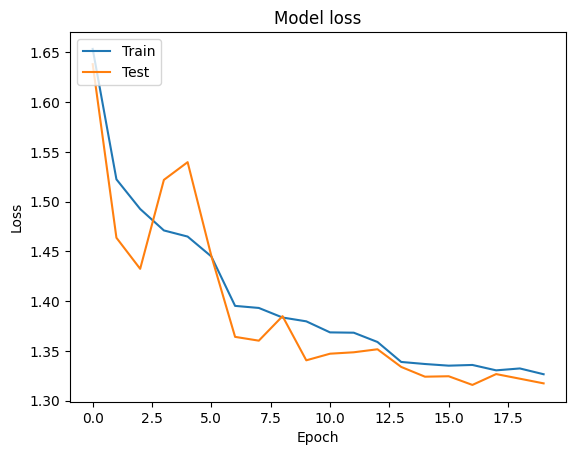

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

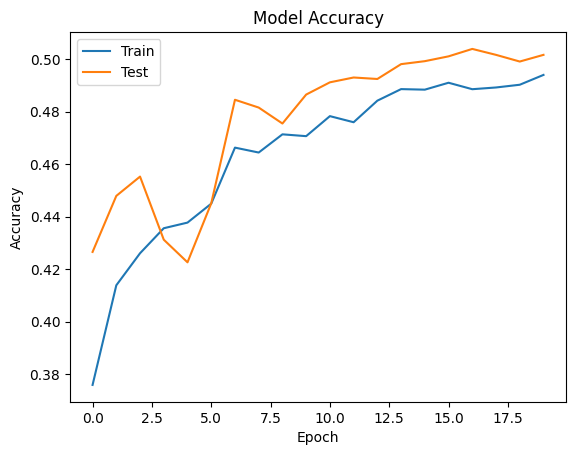

In [20]:
# Plot training & validation loss values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
model.save('emotion_detection_model.h5')